## Imports

In [84]:
# Standard library
import os
import glob
from pathlib import Path
from itertools import groupby
from joblib import Parallel, delayed

# Numerics - data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import seaborn as sns

# Stats - signal
import scipy.stats as stats
from scipy.stats import zscore, pearsonr, mannwhitneyu, chi2
from scipy.signal import welch, butter, filtfilt
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator
from sklearn.isotonic import spearmanr
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

# PCA - scaling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# HMM
import jax
import jax.numpy as jnp
from dynamax.hidden_markov_model import GaussianHMM

# OT
import ot

## Utils 

In [ ]:
def load_fMRI(data_root, file_pattern):
    '''
    Load fMRI time series from a BIDS-like directory tree
    '''
    data = []
    subjects = []
    errors = 0

    # iterate subject folders (sub-*)
    subs = sorted(d for d in os.listdir(data_root)
                  if os.path.isdir(os.path.join(data_root, d)) and d.startswith("sub-"))
    for sub in subs:
        sub_path = os.path.join(data_root, sub)

        # iterate session folders (ses-*)
        ses_list = sorted(s for s in os.listdir(sub_path)
                          if os.path.isdir(os.path.join(sub_path, s)) and s.startswith("ses-"))
        for ses in ses_list:
            func_dir = os.path.join(sub_path, ses, "func")
            if not os.path.isdir(func_dir):
                continue

            # find matching files in func/
            pattern = os.path.join(func_dir, file_pattern)
            matched = glob.glob(pattern)
            if not matched:
                print(f"No files found for {sub}/{ses} with pattern {file_pattern}")
                continue

            for fp in matched:
                try:
                    df = pd.read_csv(fp, sep="\t")
                    arr = df.values  # parcels x time
                    data.append(arr)
                    subjects.append(f"{sub}_{ses}")
                except Exception as e:
                    print(f"Error loading {fp}: {e}")
                    errors += 1

    print(f"Loaded {len(data)} subjects with shape {np.shape(data[0])}")
    return np.array(data), np.array(subjects)  # data shape: subjects x parcels x time


def zscore_fmri(fmri_data):
    '''
    Z-score the fMRI data (fmri_data shape: subjects x parcels x time)
    '''
    fmri_data_z = []
    for subject_data in fmri_data:
        subject_data_z = zscore(subject_data, axis=1)
        fmri_data_z.append(subject_data_z)
        
    return np.array(fmri_data_z)


def compute_fc(signal: np.ndarray) -> np.ndarray:
    '''
    Compute functional connectivity (FC) matrix (signal shape: parcels x time)
    '''
    return np.corrcoef(signal)


def compute_pca(X, n_components=None):
    '''
    Compute PCA (X shape: samples x features matrix)
    '''
    # fit PCA and project data
    pca = PCA(n_components=n_components, svd_solver="full")
    proj = pca.fit_transform(X)
    return proj, pca.explained_variance_ratio_, pca.components_

## Plotting 

In [ ]:
def plot_matrices(matrices, network_labels, network_names, titles=None, vminvmax=[-1, 1], cmap='RdBu_r', figsize_per_matrix=(5, 4), sort=True):
    '''
    Plot one or more matrices (FC) with network labels and names
    '''
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(figsize_per_matrix[0] * num_matrices, figsize_per_matrix[1]), constrained_layout=True)
    if num_matrices == 1:
        axes = [axes]

    # Ensure labels are numpy array
    network_labels = np.array(network_labels)

    # Initialize tick positions and labels
    tick_positions = []
    label_positions = []
    tick_labels = []

    if sort:
        _, sorted_labels = np.unique(network_labels, return_inverse=True)
        sorted_indices = np.argsort(sorted_labels)

        prev_label = sorted_labels[sorted_indices[0]]
        start_idx = 0
        for i, label in enumerate(sorted_labels[sorted_indices]):
            if label != prev_label:
                tick_positions.append(i)
                label_positions.append((start_idx + i - 1) / 2)
                tick_labels.append(network_names[prev_label])
                start_idx = i
                prev_label = label
        tick_positions.append(len(sorted_labels))
        label_positions.append((start_idx + len(sorted_labels) - 1) / 2)
        tick_labels.append(network_names[prev_label])

    else:
        assert isinstance(network_labels, (np.ndarray, list))
        sorted_indices = np.arange(len(network_labels))

        network_labels = np.array(network_labels)
        prev_label = network_labels[0]
        start = 0
        for i, label in enumerate(network_labels):
            if label != prev_label:
                tick_positions.append(i)
                label_positions.append((start + i - 1) / 2)
                tick_labels.append(network_names[prev_label])
                start = i
                prev_label = label
        tick_positions.append(len(network_labels))
        label_positions.append((start + len(network_labels) - 1) / 2)
        tick_labels.append(network_names[prev_label])

    # Plot each matrix
    for i, (matrix, ax) in enumerate(zip(matrices, axes)):
        mat_to_plot = matrix[np.ix_(sorted_indices, sorted_indices)] if sort else matrix

        heatmap = sns.heatmap(mat_to_plot, ax=ax, cmap=cmap, center=0, vmin=vminvmax[0], vmax=vminvmax[1], square=True, xticklabels=False, yticklabels=False, cbar=True, cbar_kws={'shrink': 1, 'pad': 0.05})

        # Style the colorbar
        cbar = heatmap.collections[0].colorbar
        if cbar:
            cbar.set_ticks([vminvmax[0], 0, vminvmax[1]])
            cbar.set_ticklabels([f"{vminvmax[0]:.1f}", "0", f"{vminvmax[1]:.1f}"])
            cbar.outline.set_edgecolor('black')  # type: ignore
            cbar.outline.set_linewidth(0.5)  # type: ignore
            cbar.ax.tick_params(labelsize=10)

        # Set tick marks
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)

        # Add network labels
        for pos, label in zip(label_positions, tick_labels):
            ax.text(pos, ax.get_ylim()[0] + 1.5, label, ha='center', va='top', fontsize=12, rotation=90)
            ax.text(ax.get_xlim()[0] - 1.5, pos, label, ha='right', va='center', fontsize=12)

        ax.tick_params(axis='both', labelsize=10)

        # Title
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=14)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)


def plot_signals(x, dt=1, n_plot=10, n_parcels=None, title=None, figsize=(10,5)):
    '''
    Plot the trajectory of a (BOLD) signal over time 
    '''
    x = x.T
    time_steps = x.shape[0]
    n_parcels = x.shape[1]

    # Generate the time array
    time = np.arange(0, time_steps * dt, dt)
    
    # Select random trajectories to plot
    random_indices = np.random.choice(n_parcels, size=n_plot, replace=False)
    selected_trajectories = x[:, random_indices]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(time, selected_trajectories, lw=1.5)
    if title is not None:
        plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('x(t)', fontsize=13)
    plt.yticks(np.array([np.round(np.max(selected_trajectories), 0), 0, np.round(np.min(selected_trajectories), 0)]))

    # Customize the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



def plot_state_means(means, network_labels, network_names, sort=True, cmap='RdBu_r', figsize=(12,4)):
    '''
    Plot the mean BOLD activity for each state, grouped by network labels
    '''
    n_states, n_parcels = means.shape
    network_labels = np.asarray(network_labels)

    # reorder columns by network_labels
    if sort:
        order = np.argsort(network_labels)
        means2 = means[:, order]
        labels2 = network_labels[order]
    else:
        means2 = means
        labels2 = network_labels

    # find where labels changes i.e. block boundaries
    boundaries = np.r_[0, np.where(np.diff(labels2) != 0)[0] + 1, n_parcels]

    # compute tick‐positions (center of each block) and tick‐labels
    start_inds = boundaries[:-1]
    end_inds   = boundaries[1:] - 1
    tick_positions = (start_inds + end_inds) / 2
    tick_labels    = [network_names[labels2[i]] for i in start_inds]

    # plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = ax.imshow(means2, aspect='auto', cmap=cmap, vmin=-means2.max(), vmax=means2.max())
    fig.colorbar(im, ax=ax, label='Mean BOLD activity')

    # draw separators
    for b in boundaries[1:-1]:
        ax.axvline(b - 0.5, color='black', lw=1, alpha=1)

    # set custom ticks
    ax.set_xticks(tick_positions)
    ax.set_yticks(np.arange(0, n_states, 1))
    ax.set_xticklabels(tick_labels, rotation=0, ha='center')
    ax.set_xlabel('Resting‐State Network')
    ax.set_ylabel('State')
    plt.tight_layout()


def add_cov_ellipse(ax, x, y, color, alpha=0.18, lw=1.2):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    if x.size < 3:
        return

    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)

    order = np.argsort(vals)[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    r2 = chi2.ppf(0.95, df=2)
    w, h = 2 * np.sqrt(np.maximum(vals, 0) * r2)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    center = (x.mean(), y.mean())
    ax.add_patch(
        Ellipse(
            center, width=w, height=h, angle=angle,
            facecolor=color, edgecolor=color, alpha=alpha, lw=lw
        )
    )
    ax.scatter(*center, s=80, marker="*", color=color, edgecolors="black", linewidths=0.6, zorder=5)


def rank_biserial(x1, x2):
    U, _ = stats.mannwhitneyu(x1, x2, alternative="two-sided")
    n1, n2 = len(x1), len(x2)
    return 2 * U / (n1 * n2) - 1


def hedges_g(x1, x2):
    n1, n2 = len(x1), len(x2)
    if n1 < 2 or n2 < 2:
        return np.nan
    v1, v2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    dof = n1 + n2 - 2
    if dof <= 0:
        return np.nan
    sp2 = ((n1-1)*v1 + (n2-1)*v2) / dof
    if sp2 <= 0:
        return np.nan
    d = (np.mean(x1) - np.mean(x2)) / np.sqrt(sp2)
    J = 1 - (3/(4*dof - 1))
    return d * J

## Global

In [173]:
# Inputs
DATA_ROOT = "/readonly/insights/bids/MS/derivatives/xcp_d"
FILE_PATTERN = "*_space-fsLR_seg-4S156Parcels*_stat-mean_timeseries.tsv"
PHENO_XLSX = "/readonly/insights/bids/MS_IDs.xlsx"

ATLAS_TSV = (
    "/readonly/insights/bids/MS/derivatives/xcp_d/atlases/"
    "atlas-4S156Parcels/atlas-4S156Parcels_dseg.tsv"
)

DATA_DIR = Path("/home/taffarello/codes/wbm_codes/HMM_OT_output/data")
FIG_DIR  = Path("/home/taffarello/codes/wbm_codes/HMM_OT_output/figures")

# Fallback to repository folders
if not DATA_DIR.exists():
    DATA_DIR = Path("../data")

if not FIG_DIR.exists():
    FIG_DIR = Path("../figures")

DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Global parameters
TR = 1.5          # repetition time in seconds
T_PER_SUBJ = 240  # number of timepoints per subject
N_PARCELS = 100   # cortical parcels
FS = 1.0 / TR

In [174]:
# Utils for plotting matrices
atlas = (
    pd.read_csv(ATLAS_TSV, sep="\t")
    .sort_values("index")
    .reset_index(drop=True)
)

# Atlas 4S156Parcels
atlas = pd.read_csv(ATLAS_TSV, sep="\t").sort_values("index").reset_index(drop=True)
labels = atlas["network_label"]

# keep only cortical parcels (subcortical/cerebellar parcels have network_label = NaN)
labels_cort = labels[labels.notna()]

codes, _ = pd.factorize(labels_cort)
network_labels = np.asarray(codes[:N_PARCELS])

# Resting-state networks
network_names = ['VN', 'SMN', 'DAN', 'VAN', 'LN', 'CN', 'DMN']

np.save(DATA_DIR / "network_labels.npy", network_labels)
np.save(DATA_DIR / "network_names.npy", network_names)

In [175]:
# Remove to and right axis from plots
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Load Data

In [176]:
# Load fMRI data
data, subjects = load_fMRI(DATA_ROOT, FILE_PATTERN)

# Load phenotype data
df = pd.read_excel(PHENO_XLSX, dtype=str)
df["participant_id"] = df["subjidx"].apply(
    lambda x: f"sub-{x}_ses-001"
)  # matches subject identifiers used in fMRI data

# Keep only subjects with valid fMRI data and enforce the same order
df_valid = (
    df[df["participant_id"].isin(subjects)]
    .set_index("participant_id")
    .loc[subjects]
    .copy()
)

# Select covariates for downstream analyses
sel_features = [
    "group", "age", "sex", "education", "EDSS",
    "SDMT", "disease_duration", "BPF", "lesion_load"
]
df_sel = df_valid[sel_features].copy()

# Save
df_sel.to_csv(DATA_DIR / "df_sel.csv", index=True)

No files found for sub-158/ses-001 with pattern *_space-fsLR_seg-4S156Parcels*_stat-mean_timeseries.tsv
No files found for sub-188/ses-001 with pattern *_space-fsLR_seg-4S156Parcels*_stat-mean_timeseries.tsv
Loaded 217 subjects with shape (240, 156)


In [177]:
# Reformat to (subjects, parcels, time) and keep cortical parcels
bold = data.transpose(0, 2, 1)[:, :N_PARCELS, :]

# Z-score subject-wise data
bold_zsc = zscore_fmri(bold)

# Split by group (HC nd MS)
groups = df_sel.loc[subjects, "group"].astype(str).values
ms_mask = groups == "MS"
hc_mask = groups == "HC"

bold_ms = bold_zsc[ms_mask]
bold_hc = bold_zsc[hc_mask]

print("bold_zsc shape:", bold_zsc.shape)  # (subjects, parcels, time)
print(f"{bold_ms.shape[0]} MS subjects and {bold_hc.shape[0]} HC subjects")

bold_zsc shape: (217, 100, 240)
122 MS subjects and 95 HC subjects


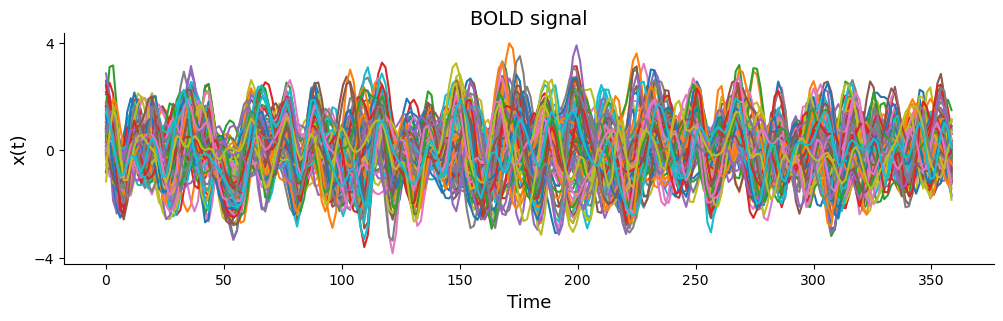

In [181]:
# Plot an example of BOLD signal
plot_signals(bold_ms[0], dt=TR, n_plot=100, title="BOLD signal", figsize=(12, 3))
plt.show()

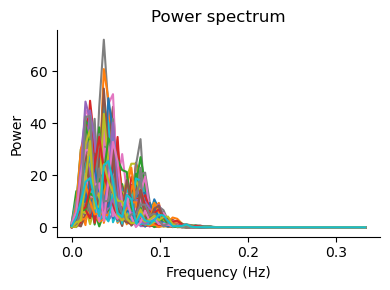

In [179]:
# Example subject
signal = bold_ms[0]  # shape: (parcels, time)

# Power spectrum (Welch)
frequencies, power_spectrum = welch(
    signal,
    fs=FS,
    axis=1,
    nperseg=128,
)

# Plot power spectrum across parcels
plt.figure(figsize=(4, 3))
for i in range(signal.shape[0]):
    plt.plot(frequencies, power_spectrum[i])

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power spectrum")
plt.tight_layout()
plt.show()


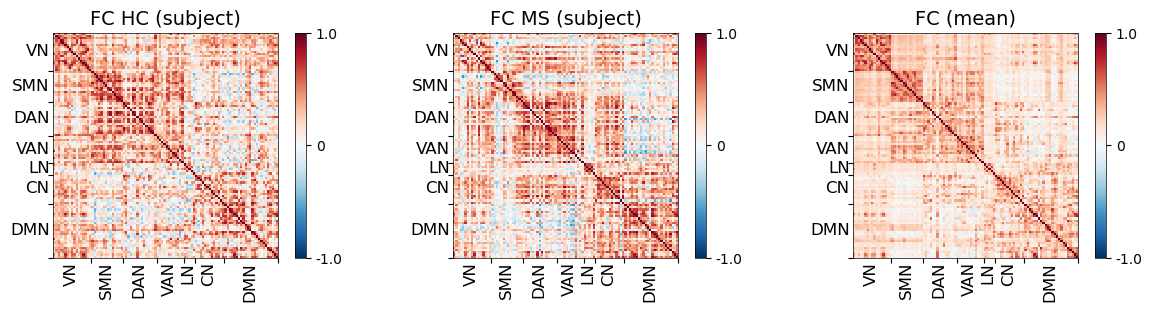

In [180]:
# Compute static FC for each subject
fcs_ms = [compute_fc(sub) for sub in bold_ms]
fcs_hc = [compute_fc(sub) for sub in bold_hc]
fcs_all = [compute_fc(sub) for sub in bold_zsc]

# Group-averaged FC
fc_mean = np.mean(fcs_all, axis=0)
fc_mean_ms = np.mean(fcs_ms, axis=0)
fc_mean_hc = np.mean(fcs_hc, axis=0)

# Plot example FC matrices
plot_matrices(
    [fcs_hc[0], fcs_ms[0], fc_mean],
    network_labels=network_labels,
    network_names=network_names,
    titles=["FC HC (subject)", "FC MS (subject)", "FC (mean)"],
    vminvmax=[-1, 1],
    cmap="RdBu_r",
    figsize_per_matrix=(4, 3),
    sort=True,
)
plt.show()

# Save all subject-level FCs
np.save(DATA_DIR / "fcs_all.npy", np.array(fcs_all))


PCA input shape (timepoints x parcels): (52080, 100)


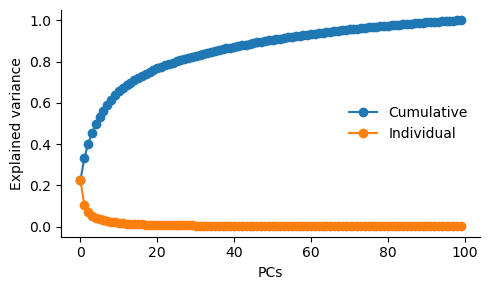

In [ ]:
# Concatenate MS and HC subjects
bold_all = bold_zsc.copy() # np.concatenate([bold_ms, bold_hc], axis=0)
n_subjects, n_parcels, n_time = bold_all.shape

# Stack time across subjects
X = bold_all.transpose(0, 2, 1).reshape(n_subjects * n_time, n_parcels)
print("PCA input shape (timepoints x parcels):", X.shape)

# PCA across timepoints
projections, explained_variance_ratio, eigenvectors = compute_pca(
    X, n_components=n_parcels
)

# Plot explained variance ratio
plt.figure(figsize=(5, 3))
plt.plot(np.cumsum(explained_variance_ratio), "o-", label="Cumulative")
plt.plot(explained_variance_ratio, "o-", label="Individual")
plt.xlabel("PCs")
plt.ylabel("Explained variance")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


## HMM - Model Selection

In [41]:
def num_params_gaussian_hmm(K, D):
    '''
    Number of parameters in a Gaussian HMM with K states and D-dimensional emissions.
    '''
    init_probs = K - 1
    transitions = K * (K - 1)
    means = K * D
    covs = K * (D * (D + 1)) // 2
    return init_probs + transitions + means + covs


def training(n_components, n_states, projections, total_time_points, n_iter=100, n_restarts=20):
    '''
    Train a Gaussian HMM on PCA projections and return LL/BIC across restarts.
    '''
    emissions = projections[:, :n_components]
    emissions_dim = emissions.shape[1]

    results = []

    for i in range(n_restarts):
        this_seed = np.random.randint(0, int(1e6))
        key = jax.random.PRNGKey(this_seed)

        hmm = GaussianHMM(n_states, emissions_dim)
        params, props = hmm.initialize(key=key, emissions=emissions)
        params, lls = hmm.fit_em(params, props, emissions, num_iters=n_iter)

        final_ll = float(lls[-1])
        num_params = num_params_gaussian_hmm(n_states, emissions_dim)
        bic = -2 * final_ll + np.log(total_time_points) * num_params

        results.append({
            "n_states": n_states,
            "n_components": n_components,
            "ll_final": final_ll,
            "bic": float(bic),
            "seed": int(this_seed),
            "restart": int(i),
            "lls": [float(l) for l in lls],
        })

    return results


In [ ]:
# HMM grid search
n_iter = 300
n_restarts = 20
n_components_list = [10, 20, 25, 30, 35, 40, 45, 60, 80]
n_states_list = [2, 3, 4, 5, 6]

total_time_points = projections.shape[0]

# Run all configurations
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(training)(
        n_components=n_components,
        n_states=n_states,
        projections=projections,
        total_time_points=total_time_points,
        n_iter=n_iter,
        n_restarts=n_restarts,
    )
    for n_states in n_states_list
    for n_components in n_components_list
)

# Collect results
df_trials = pd.DataFrame(
    [r for sublist in results if sublist is not None for r in sublist]
)

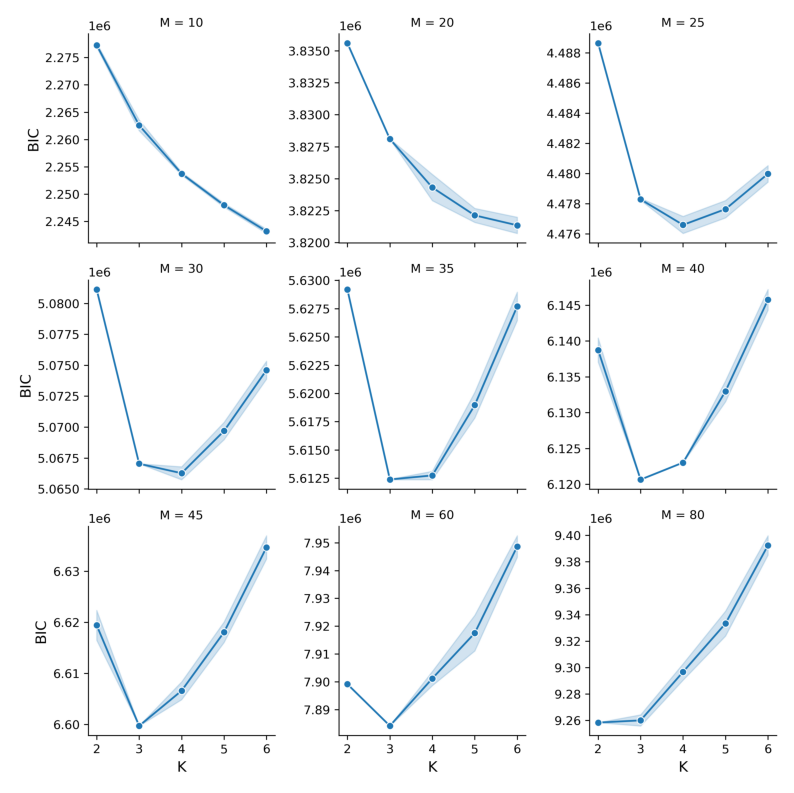

In [46]:
g = sns.FacetGrid(df_trials, col="n_components", col_wrap=3, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x="n_states",
    y="bic",
    errorbar="sd",
    marker="o"
)
g.set_titles("M = {col_name}", fontsize=13)
g.set_axis_labels("K", "BIC", fontsize=12)

plt.tight_layout()
plt.savefig(FIG_DIR / "MS_bic_vs_states.png", dpi=300, bbox_inches="tight")
plt.show()

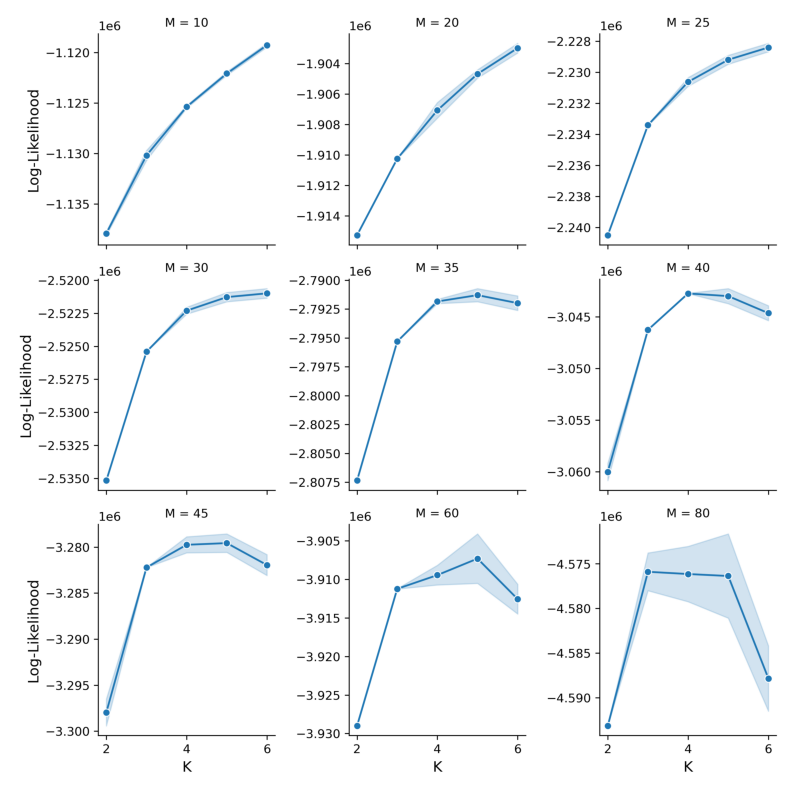

In [48]:
g = sns.FacetGrid(df_trials, col="n_components", col_wrap=3, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x="n_states",
    y="ll_final",
    errorbar="sd",
    marker="o"
)
g.set_titles("M = {col_name}", fontsize=13)
g.set_axis_labels("K", "Log-Likelihood", fontsize=12)

plt.tight_layout()
plt.savefig(FIG_DIR / "MS_ll_vs_states.png", dpi=300, bbox_inches="tight")
plt.show()

## HMM Fit 

In [55]:
selected_n_components = 30
selected_n_states = 3
n_iter = 300
n_restarts = 10

emissions = jnp.asarray(projections[:, :selected_n_components])
emissions_dim = emissions.shape[1]

best_ll = -np.inf
best_hmm = None
best_params = None
best_props = None
best_lls = None
best_seed = None

for i in range(n_restarts):
    seed = np.random.randint(0, int(1e6)) 
    key = jax.random.PRNGKey(seed)

    hmm = GaussianHMM(selected_n_states, emissions_dim)
    params, props = hmm.initialize(key=key, emissions=emissions)
    params, lls = hmm.fit_em(params, props, emissions, num_iters=n_iter)

    final_ll = float(lls[-1])

    if final_ll > best_ll:
        best_ll = final_ll
        best_hmm = hmm
        best_params = params
        best_props = props
        best_lls = [float(l) for l in lls]
        best_seed = seed

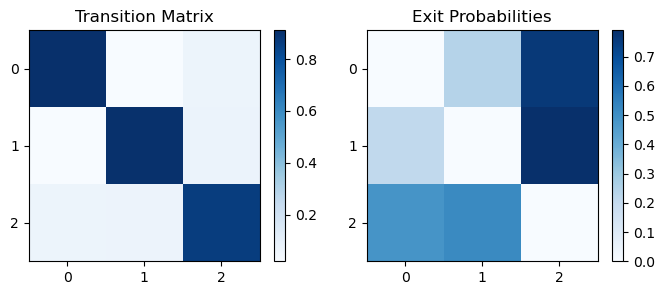

In [ ]:
# Estimated transition matrix
A_est = best_params.transitions.transition_matrix  # type: ignore

# Exit probabilities: remove self-transitions and renormalize rows
A_exit_est = A_est - np.diag(np.diag(A_est))
row_sum = A_exit_est.sum(axis=1, keepdims=True)
A_exit_est = np.divide(A_exit_est, row_sum, where=row_sum != 0)

# Plot transition matrices
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

im0 = axs[0].imshow(A_est, cmap="Blues")
axs[0].set_title("Transition Matrix")
axs[0].set_yticks(np.arange(selected_n_states))
plt.colorbar(im0, ax=axs[0], fraction=0.046)

im1 = axs[1].imshow(A_exit_est, cmap="Blues")
axs[1].set_title("Exit Probabilities")
axs[1].set_yticks(np.arange(selected_n_states))
plt.colorbar(im1, ax=axs[1], fraction=0.046)
plt.savefig(FIG_DIR / "HMM_transition_matrices.png", dpi=300, bbox_inches="tight")
plt.show()


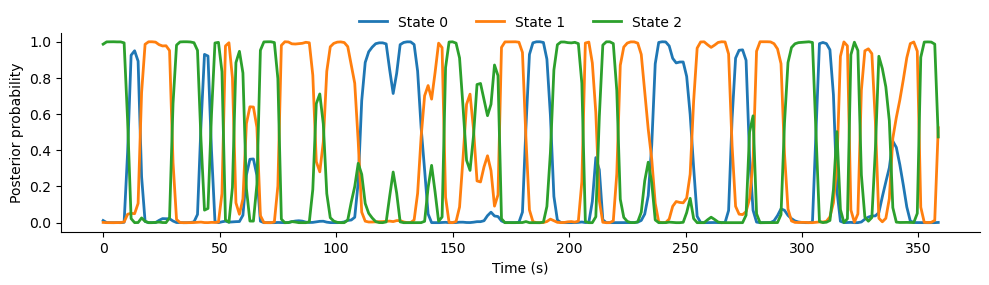

In [ ]:
# Extract posterior state probabilities (gamma) and viterbi path (hard states)
post = best_hmm.smoother(best_params, emissions)
gamma_all = np.array(post.smoothed_probs)  # (T_total, K)
path_all = np.array(best_hmm.most_likely_states(best_params, emissions))  # (T_total, K)

T_total, K = gamma_all.shape

# Plot posterior probabilities for one subject
fig, ax = plt.subplots(figsize=(10, 3))

sub_idx = np.random.randint(0, n_subjects)
subj_time = T_PER_SUBJ  # timepoints per subject
time = np.arange(subj_time) * TR
t_slice = slice(sub_idx * subj_time, (sub_idx + 1) * subj_time)

for k in range(selected_n_states):
    ax.plot(time, gamma_all[t_slice, k], label=f"State {k}", linewidth=2)

ax.set_ylabel("Posterior probability")
ax.set_xlabel("Time (s)")

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=selected_n_states,
    frameon=False
)

plt.tight_layout()
plt.show()

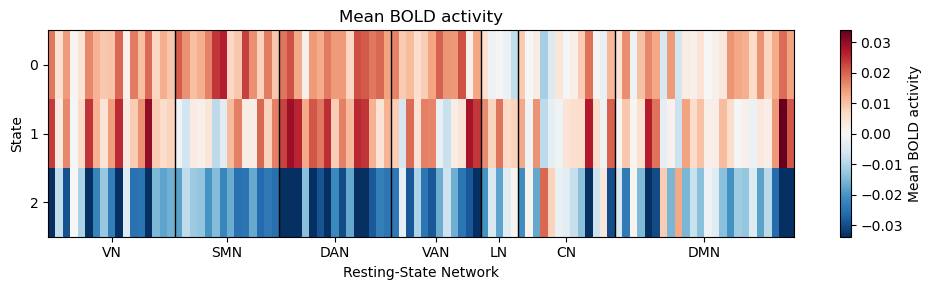

In [ ]:
# Back-project HMM parameters from PCA space to parcel space
# K states, M PCA components, N parcels
U = np.asarray(eigenvectors[:selected_n_components, :])  # (M, N)

means_pca = np.asarray(best_params.emissions.means)  # (K, M)  
means_orig = means_pca @ U  # (K, N)

np.save(DATA_DIR / "means_orig.npy", means_orig)

plot_state_means(means_orig, network_labels, network_names, sort=True, figsize=(10, 3))
plt.title("Mean BOLD activity")
plt.tight_layout()
plt.show()

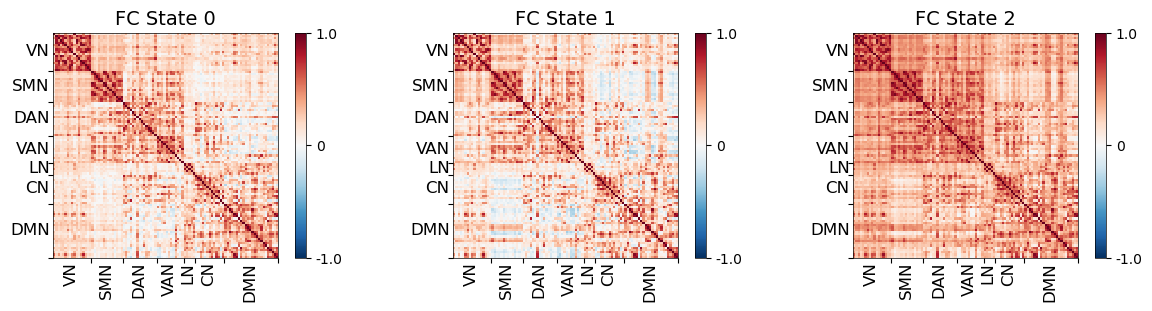

In [127]:
# Covariances / FC back-projection
covs_pca = np.asarray(best_params.emissions.covs)  # (K, M, M)

covs_orig, fcs_orig = [], []
for k in range(selected_n_states):
    cov_orig = U.T @ covs_pca[k] @ U  # (N, N)

    d = np.sqrt(np.diag(cov_orig))
    denom = np.outer(d, d)
    fc_orig = np.divide(cov_orig, denom, out=np.zeros_like(cov_orig), where=denom != 0)

    covs_orig.append(cov_orig)
    fcs_orig.append(fc_orig)

covs_orig = np.stack(covs_orig)  # (K, N, N)
fcs_orig  = np.stack(fcs_orig)  # (K, N, N)

np.save(DATA_DIR / "covs_orig.npy", covs_orig)
np.save(DATA_DIR / "fcs_orig.npy", fcs_orig)

plot_matrices(
    fcs_orig,
    network_labels=network_labels,
    network_names=network_names,
    titles=[f"FC State {i}" for i in range(selected_n_states)],
    figsize_per_matrix=(4, 3),
    sort=True
)
plt.show()

In [135]:
# Compute metrics for each subject and state
T = T_PER_SUBJ
K = gamma_all.shape[1]

records = []

for s, pid in enumerate(subjects):
    start, stop = s * T, (s + 1) * T

    gamma = gamma_all[start:stop]   # (T, K)
    path  = path_all[start:stop]    # (T,)

    switch_rate = np.mean(path[1:] != path[:-1])

    group = df_sel.loc[pid, "group"]

    for k in range(K):
        fo_soft = gamma[:, k].mean()
        fo_hard = np.mean(path==k)
        
        runs = [len(list(g)) for st, g in groupby(path) if st == k]
        dwell = np.mean(runs) if runs else 0.0
        dwell *= TR  # convert to seconds using TR

        rec = {
            "participant_id": pid,
            "Group": group,
            "State": f"State{k}",
            "FO_soft": fo_soft,
            "FO_hard": fo_hard,
            "Dwell": dwell,
            "SwitchRate": switch_rate,
        }

        records.append(rec)

df_hmm = pd.DataFrame.from_records(records)

# Save metrics
df_hmm.to_csv(DATA_DIR / "df_hmm_metrics.csv", index=False)

In [199]:
# Group comparison 
metrics_state = ["FO_soft", "Dwell"]  # per-state metrics to be compared
states = sorted(df_hmm["State"].unique())

tests, pvals = [], []

# MS vs HC within each state
for metric in metrics_state:
    for st in states:
        grp_ms = df_hmm.query("Group=='MS' and State==@st")[metric].dropna()
        grp_hc = df_hmm.query("Group=='HC' and State==@st")[metric].dropna()
        p = mannwhitneyu(grp_ms, grp_hc, alternative="two-sided").pvalue
        tests.append((metric, st))
        pvals.append(p)

# MS vs HC for switching rate
cols_sr = ["participant_id", "Group", "SwitchRate"]

# Take the first (and only) row per participant, since SwitchRate is the same across states
df_sr = (df_hmm.groupby("participant_id", as_index=False).agg(Group=("Group", "first"),SwitchRate=("SwitchRate", "first")))
sr_ms = df_sr.query("Group=='MS'")["SwitchRate"].dropna()
sr_hc = df_sr.query("Group=='HC'")["SwitchRate"].dropna()
p_sr = mannwhitneyu(sr_ms, sr_hc, alternative="two-sided").pvalue
tests.append(("SwitchRate", None))
pvals.append(p_sr)

# FDR (global over all tests above)
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
results = {
    test: {"p_unc": p_u, "p_fdr": p_f, "significant": sig}
    for test, p_u, p_f, sig in zip(tests, pvals, pvals_fdr, reject)
}

# print results
print("Metric      State      p_unc      p_fdr     sig")
print("-------------------------------------------------")
for (metric, st), vals in results.items():
    st_lab = st if st is not None else "-"
    print(f"{metric:11} {st_lab:10} {vals['p_unc']:.4f}    {vals['p_fdr']:.4f}    {vals['significant']}")

Metric      State      p_unc      p_fdr     sig
-------------------------------------------------
FO_soft     State0     0.0147    0.0343    True
FO_soft     State1     0.0051    0.0343    True
FO_soft     State2     0.3062    0.3251    False
Dwell       State0     0.0446    0.0780    False
Dwell       State1     0.0122    0.0343    True
Dwell       State2     0.3251    0.3251    False
SwitchRate  -          0.1335    0.1869    False


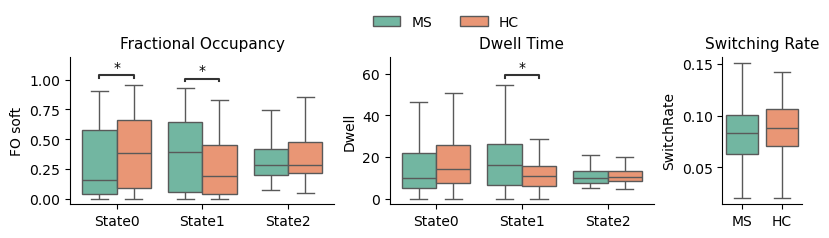

In [ ]:
# Plot
fig = plt.figure(figsize=(8, 2), constrained_layout=True)
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 0.3], height_ratios=[1])

titles = ["Fractional Occupancy", "Dwell Time", "Switching Rate"]
metrics_plot = ["FO_soft", "Dwell", "SwitchRate"]

for i, (metric, title) in enumerate(zip(metrics_plot, titles)):
    ax = fig.add_subplot(gs[0, i])

    if metric != "SwitchRate":
        sns.boxplot(
            data=df_hmm, x="State", y=metric, hue="Group",
            showfliers=False, palette="Set2", ax=ax
        )
        ax.set_xlabel("")
        ax.set_ylabel(metric.replace("_", " "))

        pairs = [((st, "MS"), (st, "HC")) for st in states]
        signif = [results[(metric, st)]["significant"] for st in states]
        pvals_plot = [results[(metric, st)]["p_fdr"] for st in states]

        filtered_pairs = [p for p, s in zip(pairs, signif) if s]
        filtered_pvals = [p for p, s in zip(pvals_plot, signif) if s]

        if filtered_pairs:
            annot = Annotator(
                ax, pairs=filtered_pairs, data=df_hmm,
                x="State", y=metric, hue="Group",
                order=states, hue_order=["MS", "HC"]
            )
            annot.configure(test=None, text_format="star", loc="inside", verbose=False)
            annot.set_pvalues(filtered_pvals)
            annot.annotate()

        ax.get_legend().remove()

    else:
        sns.boxplot(
            data=df_sr, x="Group", y="SwitchRate",
            hue="Group", palette="Set2", legend=False,
            showfliers=False, ax=ax
        )
        ax.set_xlabel("")
        ax.set_ylabel("SwitchRate")

        if results[("SwitchRate", None)]["significant"]:
            pval_sr = results[("SwitchRate", None)]["p_fdr"]
            annot = Annotator(
                ax, pairs=[("MS", "HC")], data=df_sr,
                x="Group", y="SwitchRate", order=["MS", "HC"]
            )
            annot.configure(test=None, text_format="star", loc="inside", verbose=False)
            annot.set_pvalues([pval_sr])
            annot.annotate()

    ax.set_title(title, fontsize=11)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.55, 1.15), ncol=2, frameon=False)

plt.show()

In [ ]:
# Correlations with clinical variables (MS)
df_hmm = pd.read_csv(DATA_DIR / "df_hmm_metrics.csv")
df_sel = pd.read_csv(DATA_DIR / "df_sel.csv")

# MS data
df_ms_hmm  = df_hmm.query("Group == 'MS'").copy()
df_ms_clin = df_sel.query("group == 'MS'").copy()
df_merged = pd.merge(df_ms_hmm, df_ms_clin, on="participant_id", suffixes=("", "_clin"))

clinical_vars = ["EDSS", "SDMT", "BPF", "lesion_load"]
hmm_metrics   = ["FO_soft", "Dwell", "SwitchRate"]
states        = sorted(df_merged["State"].unique())

for col in clinical_vars + hmm_metrics:
    df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce")

# sanity check
if df_merged[clinical_vars + hmm_metrics].isna().any().any():
    raise ValueError("Missing values found in data used for correlations")

rows = []
for st in states:
    df_state = df_merged[df_merged["State"] == st]
    for hmm_var in hmm_metrics:
        for clin_var in clinical_vars:
            x = df_state[hmm_var]
            y = df_state[clin_var]
            rho, pval = spearmanr(x, y)
            rows.append({
                "State": st,
                "HMM_metric": hmm_var,
                "Clinical_var": clin_var,
                "Spearman_rho": rho,
                "p_value": pval,
            })

df_corr = pd.DataFrame(rows)

reject, pvals_fdr, _, _ = multipletests(df_corr["p_value"], method="fdr_bh")
df_corr["p_fdr"] = pvals_fdr
df_corr["significant"] = reject

df_corr.to_csv(DATA_DIR / "df_hmm_corr.csv", index=False)
print('Significant correlations after FDR correction:')
df_corr[df_corr["significant"] == True]

Significant correlations after FDR correction:


,State,HMM_metric,Clinical_var,Spearman_rho,p_value,p_fdr,significant
2,State0,FO_soft,BPF,0.377408,0.000020,0.000356,True
3,State0,FO_soft,lesion_load,-0.284108,0.001588,0.014292,True
6,State0,Dwell,BPF,0.416134,0.000002,0.000074,True
7,State0,Dwell,lesion_load,-0.308689,0.000571,0.006856,True
14,State1,FO_soft,BPF,-0.258610,0.004182,0.030113,True


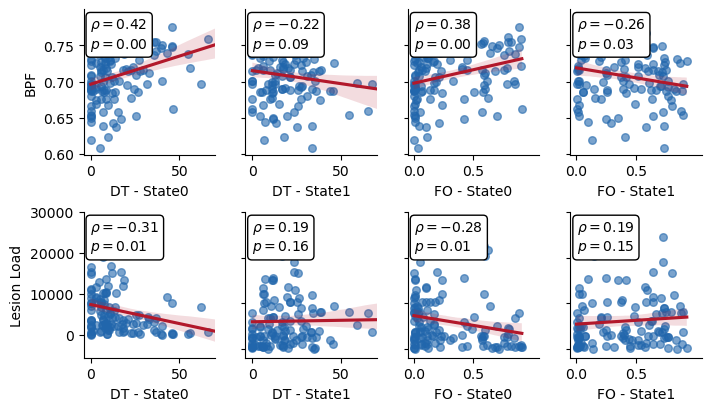

In [215]:
# plot correlations for selected metrics and clinical variables
metrics_to_plot = ["Dwell", "FO_soft"]
clinical_vars_to_plot = ["BPF", "lesion_load"]
states_to_plot = ["State0", "State1"]

scatter_color = "#2166ac"
line_color = "#b2182b"
label_map = {"BPF": "BPF", "lesion_load": "Lesion Load"}

nrows = len(clinical_vars_to_plot)
ncols = len(metrics_to_plot) * len(states_to_plot)

fig = plt.figure(figsize=(7, nrows * 2), constrained_layout=True)
gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.15)

for r, clin_var in enumerate(clinical_vars_to_plot):
    for m, metric in enumerate(metrics_to_plot):
        for s, st in enumerate(states_to_plot):
            c = m * len(states_to_plot) + s
            ax = fig.add_subplot(gs[r, c])

            df_state = df_merged[df_merged["State"] == st].copy()
            x = df_state[metric]
            y = df_state[clin_var]

            info = df_corr.query(
                "State == @st and HMM_metric == @metric and Clinical_var == @clin_var"
            )
            if info.empty:
                ax.axis("off")
                continue

            rho = float(info["Spearman_rho"].iloc[0])
            p_fdr = float(info["p_fdr"].iloc[0])

            sns.regplot(
                x=x, y=y, ax=ax,
                scatter_kws={"s": 30, "alpha": 0.6, "color": scatter_color},
                line_kws={"color": line_color},
            )

            metric_label = metric.replace("_", " ")
            if metric == "Dwell":
                metric_label = "DT"
                ax.set_xticks([0, 50])
                ax.set_xlim(-4, 70)

            elif metric == "FO_soft":
                metric_label = "FO"
                ax.set_xticks([0, 0.5])
                ax.set_xlim(-0.05, 1.05)

            ax.set_xlabel(f"{metric_label} - {st}")

            if c == 0:
                ax.set_ylabel(label_map.get(clin_var, clin_var))
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])
                ax.tick_params(axis="y", length=3)

            if clin_var == "lesion_load":
                ax.set_ylim(top=30000)

            ax.text(
                0.05, 0.95,
                rf"$\rho = {rho:.2f}$" + "\n" + rf"$p = {p_fdr:.2f}$",
                transform=ax.transAxes,
                fontsize=10,
                va="top",
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
            )

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

plt.show()


## Optimal Transport 

In [ ]:
def compute_fo(path_all, gamma_all, T, method="soft"):
    '''
    Computes fractional occupancy for each subject using either hard (viterbi) or soft (gamma) assignments
    '''
    N_subjects = len(path_all) // T
    K = gamma_all.shape[1]
    fo_all = []

    for s in range(N_subjects):
        start, stop = s * T, (s + 1) * T

        fo = np.zeros(K)  # initialization

        if method == "hard":
            path = path_all[start:stop]
            fo = np.bincount(path, minlength=K) / float(T)

        elif method == "soft":
            gamma = gamma_all[start:stop]
            fo = gamma.mean(axis=0)

        fo = fo / fo.sum()  # ensure normalization (numerical stability)
        fo_all.append(fo)

    return fo_all


def compute_transition_matrices(path_all, T, K, smoothing=1e-3, normalize=False):
    '''
    Compute subject-specific transition matrices
    '''
    N_subjects = len(path_all) // T
    Q_all = []

    for s in range(N_subjects):
        start, stop = s * T, (s + 1) * T
        path = path_all[start:stop]

        trans = np.zeros((K, K), dtype=float)
        for t in range(T - 1):
            trans[path[t], path[t + 1]] += 1.0

        trans += float(smoothing)  # Laplace smoothing

        if normalize:
            trans /= trans.sum(axis=1, keepdims=True)  # conditional P(j|i)
            Q_all.append(trans)
        else:
            Q_all.append(trans / trans.sum())  # joint P(i,j) 
    return Q_all


def f(G):
    G = np.maximum(G, 1e-15)  
    return np.sum(G * np.log(G))


def df(G):
    G = np.maximum(G, 1e-15)  
    return np.log(G) + 1.0


def kl(P, Q):
    '''
    Compute KL divergence 
    '''
    P = np.maximum(P, 1e-15)  
    Q = np.maximum(Q, 1e-15)  
    P = P / P.sum()
    Q = Q / Q.sum()
    return np.sum(P * (np.log(P) - np.log(Q)))


def compute_ot_costs(fo_all, Q_all, eps=1.0):
    '''
    compute subject pairwise OT cost (entropy regularized optimal transport)
    '''
    N = len(fo_all)
    cost_matrix = np.zeros((N, N), dtype=float)

    for i in range(N):
        print(i)
        a = fo_all[i]
        Q_i = Q_all[i].copy()

        Q_i = np.maximum(Q_i, 1e-15)
        Q_i = Q_i / Q_i.sum()

        M = -np.log(Q_i)

        for j in range(N):
            b = fo_all[j]
            P = ot.optim.cg(a, b, M, eps, f, df, verbose=False)
            cost_matrix[i, j] = kl(P, Q_i)

    return cost_matrix

In [ ]:
T = T_PER_SUBJ
K = gamma_all.shape[1]

# FO per subject (soft)
fo_all = compute_fo(path_all, gamma_all, T, method="soft")

# Q_ij per subject (joint probabilities)
Q_all = compute_transition_matrices(path_all, T, K, smoothing=1e-3, normalize=False)

# Directional cost matrix
C_dir = compute_ot_costs(fo_all, Q_all, eps=1.0)

np.save(DATA_DIR / "OT_cost_matrix.npy", C_dir)

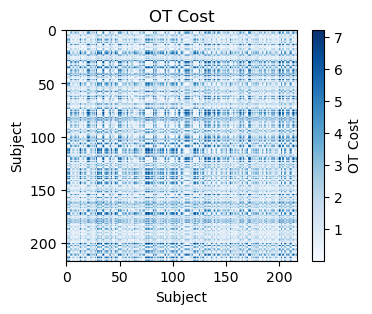

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(C_dir, cmap='Blues', aspect='equal')
plt.colorbar(label='OT Cost')
plt.title('OT Cost')
plt.xlabel('Subject')
plt.ylabel('Subject')
plt.savefig(FIG_DIR / "OT_cost_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

## Clustering

In [ ]:
# MS clustering based on OT cost
C_full = np.load(DATA_DIR / "OT_cost_matrix.npy")

# Symemtrize cost matrix (mean cost from each pair of subjects)
C_sym = 0.5 * (C_full + C_full.T)
np.fill_diagonal(C_sym, 0.0)  # ensure diagonal is zero

# Keep only MS subjects
groups = df_sel.loc[subjects, "group"].astype(str).values
ms_mask = groups == "MS"
ms_idx = np.where(ms_mask)[0]

C_ms = C_sym[np.ix_(ms_idx, ms_idx)]

# Select number of cluster via silhouette 
k_range = range(2, 6)
linkage = "average"

rows = []
best = {"k": None, "sil": -np.inf, "labels": None}

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage=linkage)
    lab = model.fit_predict(C_ms)
    sil = silhouette_score(C_ms, lab, metric="precomputed")
    rows.append({"k": k, "silhouette": sil})
    if sil > best["sil"]:
        best.update({"k": k, "sil": sil, "labels": lab})

df_k = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
print(df_k)
print(f"Best k = {best['k']} (silhouette = {best['sil']:.4f})")

best_k = best["k"]
labels_ms = best["labels"]  # cluster labels for MS subjects

   k  silhouette
0  2    0.694328
1  3    0.610513
2  4    0.559423
3  5    0.512673
Best k = 2 (silhouette = 0.6943)


/home/taffarello/miniconda3/envs/hmm_full_env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


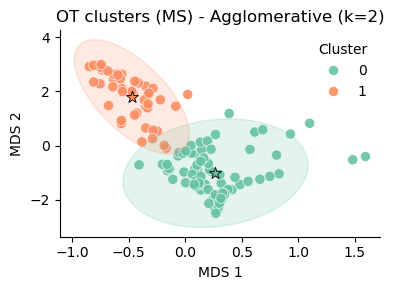

In [195]:
# embedding MDS
emb = MDS(dissimilarity="precomputed", random_state=37).fit_transform(C_ms)  # set random state to ensure reproducibility of the embedding

# MS dataframe with cluster labels and MDS embedding
ms_df = df_sel.loc[subjects].iloc[ms_idx].copy()
ms_df = ms_df.reset_index().rename(columns={"index": "participant_id"})
ms_df["OT_cluster"] = labels_ms.astype(int)
ms_df["OT_dim1"] = emb[:, 0]
ms_df["OT_dim2"] = emb[:, 1]
ms_df.to_csv(DATA_DIR / "ms_df_ot_clusters.csv", index=False)

# Plot OT clusters
plt.figure(figsize=(4, 3))
ax = plt.gca()
cluster_levels = sorted(ms_df["OT_cluster"].unique())
palette = dict(zip(cluster_levels, sns.color_palette("Set2", n_colors=len(cluster_levels))))

sns.scatterplot(
    data=ms_df,
    x="OT_dim1", y="OT_dim2",
    hue="OT_cluster", hue_order=cluster_levels,
    palette=palette,
    edgecolor="white", linewidth=0.6,
    s=55, alpha=0.9,
    ax=ax
)

for lab in cluster_levels:
    d = ms_df.query("OT_cluster == @lab")
    add_cov_ellipse(ax, d["OT_dim1"].values, d["OT_dim2"].values, color=palette[lab])

ax.set_xlabel("MDS 1")
ax.set_ylabel("MDS 2")
ax.set_title(f"OT clusters (MS) - Agglomerative (k={best_k})")
ax.legend(frameon=False, title="Cluster", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
# Anlysis of clinical variables across OT clusters
cluster_col = "OT_cluster"
cluster_levels = [0, 1]

outcomes = ["EDSS", "BPF", "lesion_load", "SDMT"]
balance_numeric = ["age", "disease_duration", "education"]
balance_cat = ["sex"]

ordinal_vars = {"edss"}  # Mann-Whitney forced (ordinal variable)

g1, g2 = cluster_levels

# ms data
ms_df[cluster_col] = pd.Categorical(ms_df[cluster_col], categories=cluster_levels, ordered=True)

for v in set(outcomes + balance_numeric):
    if v in ms_df.columns:
        ms_df[v] = pd.to_numeric(ms_df[v], errors="coerce")

if "sex" in ms_df.columns:
    ms_df["sex"] = ms_df["sex"].astype("category")

# Shapiro-Wilk test for normality (not very useful but reported for completeness)
rows_shap = []

vars_for_shap = [v for v in outcomes + balance_numeric if v in ms_df.columns]

for var in vars_for_shap:
    s0 = ms_df.loc[ms_df[cluster_col] == cluster_levels[0], var]
    s1 = ms_df.loc[ms_df[cluster_col] == cluster_levels[1], var]

    _, p0 = stats.shapiro(s0)
    _, p1 = stats.shapiro(s1)

    rows_shap.append({
        "Variable": var,
        f"p_cluster_{cluster_levels[0]}": float(p0),
        f"p_cluster_{cluster_levels[1]}": float(p1),
    })

df_shapiro = pd.DataFrame(rows_shap)


def pick_test(var):
    '''
    Pick test based on Shapiro results and variable type (results to be checked)
    '''
    if var.lower() in ordinal_vars:
        return "MW"
    row = df_shapiro.loc[df_shapiro["Variable"] == var].iloc[0]
    p0 = row[f"p_cluster_{cluster_levels[0]}"]
    p1 = row[f"p_cluster_{cluster_levels[1]}"]
    if pd.notna(p0) and pd.notna(p1) and (p0 > 0.05) and (p1 > 0.05):
        return "Welch"
    return "MW"


# Clinical variables 
rows_out = []

for var in outcomes:
    if var not in ms_df.columns:
        continue

    x1 = ms_df.loc[ms_df[cluster_col] == g1, var].to_numpy()
    x2 = ms_df.loc[ms_df[cluster_col] == g2, var].to_numpy()

    _, p_welch = stats.ttest_ind(x1, x2, equal_var=False)
    _, p_mw = stats.mannwhitneyu(x1, x2, alternative="two-sided")

    main = pick_test(var)
    p_main = p_welch if main == "Welch" else p_mw

    es = hedges_g(x1, x2) if main == "Welch" else rank_biserial(x1, x2)
    es_name = "Hedges_g" if main == "Welch" else "RankBiserial_r"

    rows_out.append({
        "Variable": var,
        "Type": "ordinal" if var.lower() in ordinal_vars else "numeric",
        "MainTest": main,
        "p_main": float(p_main),
        "p_welch": float(p_welch),
        "p_mw": float(p_mw),
        "ES": float(es),
        "ES_name": es_name
    })

df_out = pd.DataFrame(rows_out)
df_out["p_fdr_main"] = multipletests(df_out["p_main"], method="fdr_bh")[1]

# Cluster balance
rows_bal = []

# numeric
for var in balance_numeric:
    if var not in ms_df.columns:
        continue

    x1 = ms_df.loc[ms_df[cluster_col] == g1, var].to_numpy()
    x2 = ms_df.loc[ms_df[cluster_col] == g2, var].to_numpy()

    _, p_welch = stats.ttest_ind(x1, x2, equal_var=False)
    _, p_mw = stats.mannwhitneyu(x1, x2, alternative="two-sided")

    main = pick_test(var)
    p_main = p_welch if main == "Welch" else p_mw

    es = hedges_g(x1, x2) if main == "Welch" else rank_biserial(x1, x2)
    es_name = "Hedges_g" if main == "Welch" else "RankBiserial_r"

    rows_bal.append({
        "Variable": var,
        "Type": "numeric",
        "MainTest": main,
        "p_main": float(p_main),
        "p_welch": float(p_welch),
        "p_mw": float(p_mw),
        "ES": float(es),
        "ES_name": es_name
    })

# Sex
if "sex" in ms_df.columns:
    cont = pd.crosstab(ms_df[cluster_col], ms_df["sex"])
    if cont.shape == (2, 2):
        _, p = stats.fisher_exact(cont)
        test = "Fisher"
    else:
        _, p, _, _ = stats.chi2_contingency(cont, correction=False)
        test = "Chi2"

    rows_bal.append({
        "Variable": "sex",
        "Type": "categorical",
        "MainTest": test,
        "p_main": float(p),
        "p_welch": np.nan,
        "p_mw": np.nan,
        "ES": np.nan,
        "ES_name": np.nan
    })

df_bal = pd.DataFrame(rows_bal)

# Print results
print("Shapiro–Wilk test for normality (per cluster)")
display(df_shapiro.sort_values("Variable").reset_index(drop=True))

print("Outcomes (p-values + Effect Size + FDR)")
display(df_out.sort_values("p_fdr_main").reset_index(drop=True))
df_out.to_csv(DATA_DIR / "cluster_clin_diff.csv", index=False)

print("Balance (p-values + Effect Size)")
display(df_bal.sort_values(["Type", "Variable"]).reset_index(drop=True))

Shapiro–Wilk test for normality (per cluster)


,Variable,p_cluster_0,p_cluster_1
0,BPF,4.843578e-01,5.463195e-01
1,EDSS,1.870205e-06,2.510997e-07
2,SDMT,3.803007e-02,2.051355e-03
3,age,1.230770e-01,1.400423e-01
4,disease_duration,4.968886e-06,4.004846e-04
5,education,4.020189e-04,2.597962e-03
6,lesion_load,2.935791e-08,4.121269e-08


Outcomes (p-values + Effect Size + FDR)


,Variable,Type,MainTest,p_main,p_welch,p_mw,ES,ES_name,p_fdr_main
0,lesion_load,numeric,MW,0.002095,0.027320,0.002095,0.336538,RankBiserial_r,0.008381
1,BPF,numeric,Welch,0.010982,0.010982,0.015382,-0.474285,Hedges_g,0.021964
2,EDSS,ordinal,MW,0.029499,0.055582,0.029499,0.234266,RankBiserial_r,0.039332
3,SDMT,numeric,MW,0.108329,0.190846,0.108329,-0.175699,RankBiserial_r,0.108329


Balance (p-values + Effect Size)


,Variable,Type,MainTest,p_main,p_welch,p_mw,ES,ES_name
0,sex,categorical,Fisher,0.156891,NaN,NaN,NaN,NaN
1,age,numeric,Welch,0.388461,0.388461,0.365793,0.170458,Hedges_g
2,disease_duration,numeric,MW,0.075328,0.038955,0.075328,0.194347,RankBiserial_r
3,education,numeric,MW,0.333757,0.385329,0.333757,-0.103147,RankBiserial_r


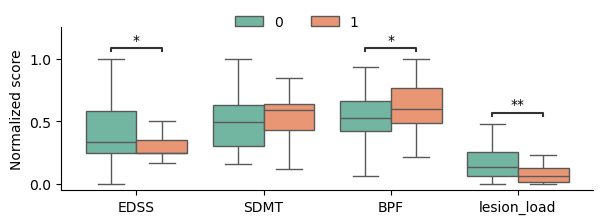

In [147]:
# Define columns
features_to_test = ["EDSS", "SDMT", "BPF", "lesion_load"]
cluster_col = "OT_cluster"

# Normalize features (min-max) + long format
scaler = MinMaxScaler()
df_scaled = ms_df[[cluster_col] + features_to_test].copy()
df_scaled[features_to_test] = scaler.fit_transform(df_scaled[features_to_test])

df_plot = pd.melt(
    df_scaled.dropna(subset=features_to_test),
    id_vars=[cluster_col],
    value_vars=features_to_test,
    var_name="Feature",
    value_name="Score",
)

cluster_levels = [0, 1]
feature_levels = features_to_test

# reuse p-values from df_out (already computed)
p_lookup = df_out.set_index("Variable")["p_fdr_main"].to_dict()

# keep only features that exist in df_out
feature_levels = [f for f in feature_levels if f in p_lookup]

# significance
alpha = 0.05
pairs_sig = [((feat, cluster_levels[0]), (feat, cluster_levels[1]))
             for feat in feature_levels if p_lookup[feat] < alpha]
pvals_sig = [p_lookup[feat] for feat in feature_levels if p_lookup[feat] < alpha]

# Plot
fig, ax = plt.subplots(figsize=(6, 2), constrained_layout=True)

sns.boxplot(
    data=df_plot, x="Feature", y="Score", hue=cluster_col,
    order=feature_levels, hue_order=cluster_levels,
    palette="Set2", showfliers=False, ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("Normalized score")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# annotate only significant features (FDR) using precomputed p-values
if pairs_sig:
    annot = Annotator(
        ax, pairs=pairs_sig, data=df_plot,
        x="Feature", y="Score", hue=cluster_col,
        order=feature_levels, hue_order=cluster_levels
    )
    annot.configure(test=None, text_format="star", loc="inside", verbose=False)
    annot.set_pvalues(pvals_sig)
    annot.annotate()

# global legend
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

fig.legend(
    handles[:len(cluster_levels)],
    labels[:len(cluster_levels)],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.08),
    ncol=len(cluster_levels),
    frameon=False,
)
plt.show()
